---
title: Classifying Palmer Penguins
author: Andrew Dean
date: '2025-02-19'
image: "palmer-penguins.png"
description: "This blog post explores the Palmer Penguins dataset to develop a classification model that can identify penguin species based on their characteristics."
code-fold: true
execute:
    warning: false
    message: false
---

## Abstract
In this analysis, I explore the Palmer Penguins dataset to develop a classification model that can identify penguin species based on their physical characteristics. Using a decision tree classifier with carefully selected features including culmen length, flipper length, and island location, I achieved high accuracy in distinguishing between Adelie, Chinstrap, and Gentoo penguins. Through exploratory data analysis and feature selection, I identified the most important predictors and optimized the model's depth parameter. The final model achieved excellent performance on the test set, with only one misclassification out of all test cases - a Gentoo penguin incorrectly identified as an Adelie. This demonstrates that penguin species can be reliably classified using a small set of physical measurements and location data.

### Data
We start by importing the Palmer Penguins dataset. Take a look at the first few rows to begin to understand the data.

In [2]:
# Importing the Palmer Penguins dataset
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


### Data Manipulation
Data preparation is essential. Some steps that we took here are:
1. Dropping the columns that are not relevant to our analysis, and then drop any rows that contain missing values. 
2. Converting the species labels into a numerical format that can be used by the model.
3. Converting the categorical features into dummy variables.
Now take a look at the first few rows of the transformed data.


In [3]:
# Data Prep
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


### Preliminary Exploration
Now that we have the data in a usable format, I started to explore the various features and their relationships. The goal of this is to guage which features might be best to use for our model.

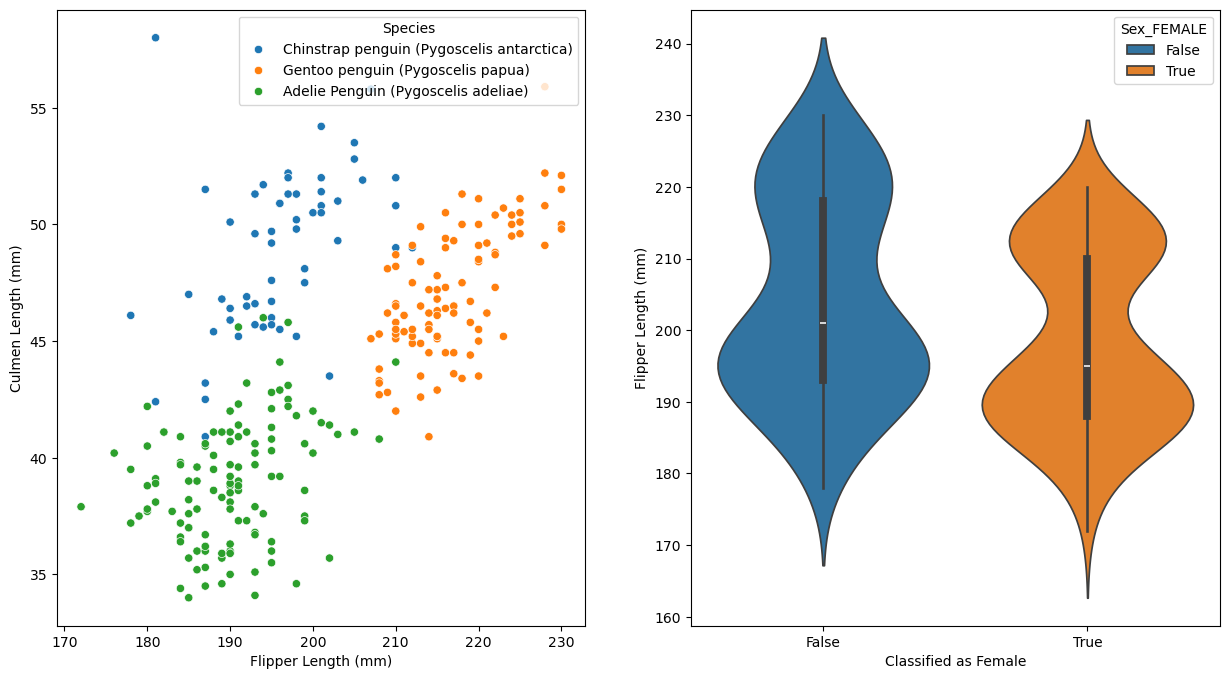

In [4]:
## Explore
# 2 interesting visualizations

from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# 1. Distribution of Culmen Length by Species
p1 = sns.scatterplot(x = "Flipper Length (mm)", y = "Culmen Length (mm)", hue = "Species", data = train, ax = axes[0])

# 2. Spread of Flipper Length by Sex
p2 = sns.violinplot(x = "Sex_FEMALE", y = "Flipper Length (mm)", hue = "Sex_FEMALE", data = X_train, ax = axes[1])
p2.set_xlabel("Classified as Female")
plt.show()

#### Figure 1 & 2.
Above I've created two visualizations to explore the data. The first shows the relationship between flipper length and culmen length for each species. The second shows the distribution of flipper length for each sex. I created the first plot because I was curious whether 1 physical characteristic might help predict the magnitude of another (ie, if a penguin has a larger flipper, does it tend to have a larger culmen?). Second, I wanted to look at the distrubutions of a physical characteristic by sex. Based on the violin plot, there is lots of overlap in flipper length between males and females, which helps us rule out sex as potential leading predictor of flipper length. And, further, this fact can likely be spread to other physical characteristics, meaning sex might not help us predict physical characteristics (and thus species) at all. 

In [5]:
# Summary Table: compute the average or median value of some features, by group

train.groupby("Species").aggregate({"Body Mass (g)": ["mean", "std"], "Culmen Length (mm)": ["mean", "std"], "Culmen Depth (mm)": ["mean", "std"], "Flipper Length (mm)": ["mean", "std"]}).round(2)


Body Mass (g)          \
                                                   mean     std   
Species                                                           
Adelie Penguin (Pygoscelis adeliae)             3718.49  462.66   
Chinstrap penguin (Pygoscelis antarctica)       3743.42  407.42   
Gentoo penguin (Pygoscelis papua)               5039.95  498.86   

                                          Culmen Length (mm)        \
                                                        mean   std   
Species                                                              
Adelie Penguin (Pygoscelis adeliae)                    38.97  2.64   
Chinstrap penguin (Pygoscelis antarctica)              48.83  3.45   
Gentoo penguin (Pygoscelis papua)                      47.07  2.74   

                                          Culmen Depth (mm)        \
                                                       mean   std   
Species                                                             
Adelie Penguin (Pygoscelis adeliae)                   18.41  1.22   
Chinstrap penguin (Pygoscelis antarctica)             18.37  1.14   
Gentoo penguin (Pygoscelis papua)                     14.91  1.00   

                                          Flipper Length (mm)        
                                                         mean   std  
Species                                                              
Adelie Penguin (Pygoscelis adeliae)                    190.08  6.69  
Chinstrap penguin (Pygoscelis antarctica)              196.00  7.42  
Gentoo penguin (Pygoscelis papua)                      216.75  5.93

### Table 1.
Here I've created a summary table that shows the average and standard deviation of body mass, culmen length, culmen depth, and flipper length for each species. This helps us become aquainted with the magnitude of our data and its distribution. Looking at the standard deviations, we can see that the relative spread of each respective characteristic is similar across species. And, right off the bat, there is not a clear unique physical characteristic that can be used to identify each species. The Gentoo penguin does quite largely have the largest body mass, but then has a similar culmen length to the Chinstrap penguin. This is important to note because it suggests that we will need to utilize multiple physical characteristics to accurately predict species. 

### Feature Selection
Feature selection is likely the most imporant step in this analysis, as the entirety of our model's performance will depend on the predictive power of our features. Below I use the SelectKBest algorithm to select the top 2 quantitative features and the top qualitative feature. 

In [13]:
## Features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Separate qualitataive and quantitative features
qualitative_features = ["Sex_FEMALE", "Sex_MALE", "Island_Biscoe", "Island_Dream", "Island_Torgersen", "Stage_Adult, 1 Egg Stage", "Clutch Completion_No", "Clutch Completion_Yes"]
quantitative_features = [col for col in X_train.columns if col not in qualitative_features]

# Select 2 quantitative features
quant_selector = SelectKBest(f_classif, k = 2)
X_train_quant = X_train[quantitative_features]
quant_selector.fit(X_train_quant, y_train)
X_new_train = quant_selector.transform(X_train_quant)
selected_quant_features = X_train_quant.columns[quant_selector.get_support()]


# Select 1 qualitataive features
qual_selector = SelectKBest(f_classif, k = 3)
X_train_qual = X_train[qualitative_features]
qual_selector.fit(X_train_qual, y_train)
X_new_train = qual_selector.transform(X_train_qual)
selected_qual_feature = X_train_qual.columns[qual_selector.get_support()]

# Combine selected quantitative and qualitative features
final_features = list(selected_quant_features) + list(selected_qual_feature)
X_new_train = X_train[final_features]
print(X_new_train.head(3))

# Top 3 features are Culmen Length (mm)  Flipper Length (mm)  and Island.


   Culmen Length (mm)  Flipper Length (mm)  Island_Biscoe  Island_Dream  \
0                40.9                187.0          False          True   
1                49.0                210.0          False          True   
2                50.0                218.0           True         False   

   Island_Torgersen  
0             False  
1             False  
2             False  


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Baseline Model
I use DecisionTreeClassifier to create a baseline model. I utilize the top 3 features that we selected above to train the model and then evaluate its performance on the training set. We achieve 100% accuracy.

In [7]:
# Initial model with top 3 features. Reached 100% accuracy on training set.

from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state = 42)
dt_classifier.fit(X_new_train, y_train)

train_accuracy = dt_classifier.score(X_new_train, y_train)
print(f"Training Accuracy: {train_accuracy:.3f}")


Training Accuracy: 1.000


### Model Optimization
Now I utilize the max_depth parameter to see if we can improve by finding the optimal depth. I use cross-validation to evaluate the performance of the model at each depth. We find that the optimal depth is 7, and this optimized model also achieves 100% accuracy on the training set.


In [8]:
# Now to utilize the max_depth parameter to see if we can improve by finding the optimal depth
from sklearn.model_selection import cross_val_score
import numpy as np

potential_depths =  range(1, 31)
mean_scores = []

for depth in potential_depths:
    classifier_instance = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    scores = cross_val_score(classifier_instance, X_new_train, y_train, cv = 5)
    mean_scores.append(scores.mean())

optimal_depth = potential_depths[np.argmax(mean_scores)]

print(f"Optimal Depth: {optimal_depth}")

# Train new model with optimal depth
dt_classifier_optimal = DecisionTreeClassifier(max_depth = optimal_depth, random_state = 42)
dt_classifier_optimal.fit(X_new_train, y_train)

train_accuracy_optimal = dt_classifier_optimal.score(X_new_train, y_train)
print(f"Training Accuracy with Optimal Depth: {train_accuracy_optimal:.3f}")





Optimal Depth: 7
Training Accuracy with Optimal Depth: 1.000


### Model Evaluation
Now we evaluate the performance of our model on the test set. We achieve 98.5% accuracy, missing only 1 penguin.

In [9]:
# Test model

test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
X_test_new = X_test[final_features]  # Use the same features selected for training
test_accuracy = dt_classifier_optimal.score(X_test_new, y_test)
print(f"Test Accuracy: {test_accuracy:.3f}")


Test Accuracy: 0.985


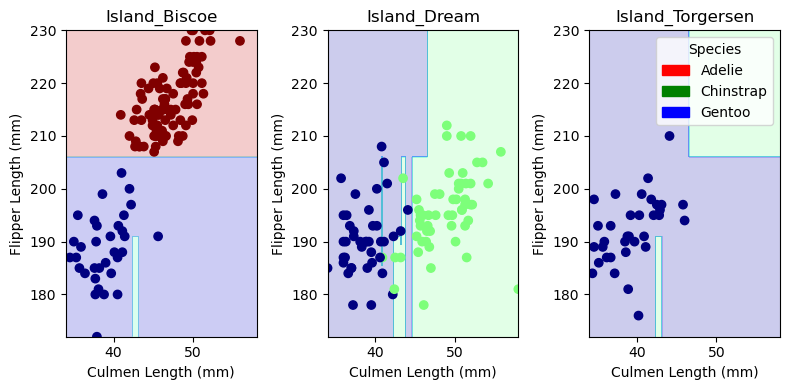

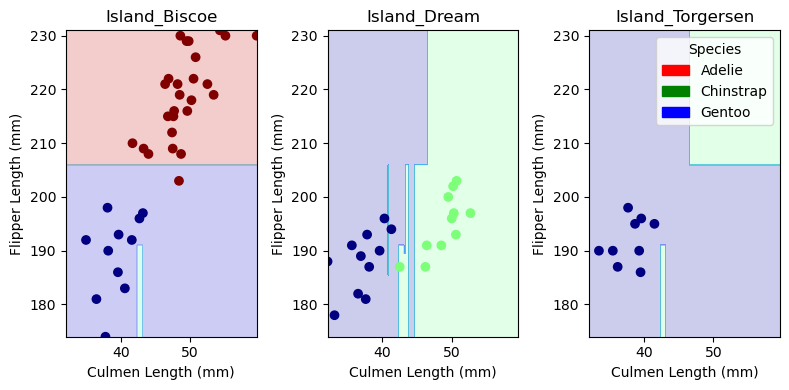

In [10]:
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (8, 4))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)

      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

cols = ["Culmen Length (mm)", "Flipper Length (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
plot_regions(dt_classifier_optimal, X_new_train, y_train)
plot_regions(dt_classifier_optimal, X_test_new, y_test)

### Figure 4 & 5.
These two 3 ply plots show the predictions of our model on the training and test sets. The model is able to predict the species of the penguin with high accuracy on both sets by using flipper length, culmen length, and the island location. We can see the 1 missclassified penguin in Figure 5.1, shown by the red dot in the blue region.

### Error Measurement
A confusion matrix is a great way to illustrate performance, showing the number of correct and incorrect predictions for each species. I created a plot to simply show this, where the shade of the cell represents the number of penguins who were classified as that species.

There were 31 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 11 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 1 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were

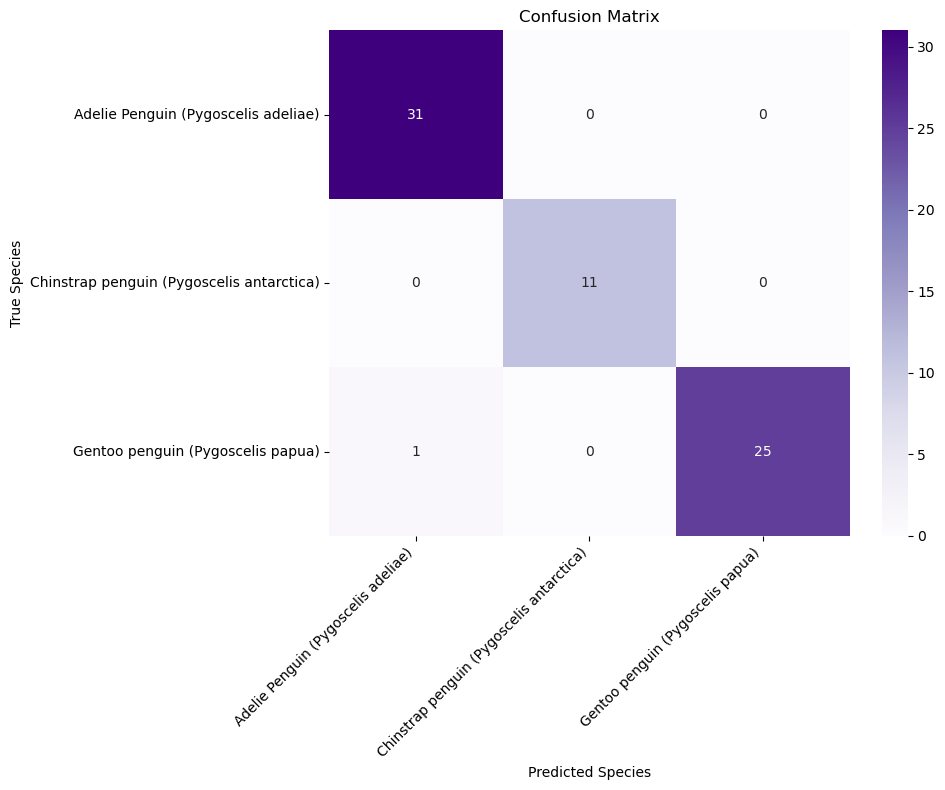

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_test_pred = dt_classifier_optimal.predict(X_test_new)
C = confusion_matrix(y_test, y_test_pred)
C
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

# Enjoy a nice visualization in the form of a heatmap
plt.figure(figsize=(10, 8))

# heatmap
sns.heatmap(C, 
            annot=True,  # show numbers in cells
            fmt='d',     # use integer format
            cmap='Purples',
            xticklabels=le.classes_,  # use species names
            yticklabels=le.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Species')
plt.ylabel('True Species')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 
The confusion matrix is evaluated on the test set. This shows that we only got 1 prediction wrong: a Gentoo was wrongly classified as a Adelie on Island Biscoe. All other classifications were correct. 

## Discussion

This analysis demonstrates the effectiveness of using decision trees for penguin species classification. Through careful feature selection, we identified that just three key features - culmen length, flipper length, and island location - were sufficient to achieve nearly perfect classification accuracy. In identifying the most useful features by using the SelectKBest algorithm (2 quantitative, 1 qualitative), we were able to maximize our model efficiency and reach a high performance.

The exploratory data analysis revealed interesting patterns in penguin morphology. The scatter plots showed clear clustering of species based on physical characteristics, though with some overlap, particularly between Adelie and Chinstrap penguins. The violin plots examining sex differences in flipper length suggested that sex was not a strong predictor of physical characteristics, which helped inform our feature selection process.

Our final model achieved high accuracy, misclassifying only one Gentoo penguin as an Adelie in the test set. This single error occurred on Biscoe Island, suggesting that while location is helpful for classification, it should not be relied upon exclusively. The confusion matrix visualization clearly showed this isolated error while highlighting the model's otherwise perfect performance.

One key aspect that I learned from this project was the importance sufficient explortion, both in feature selection and model parameter tuning. It would be easy to pick 3 features that may look promising after pre-analyis plotting, but following a precise process to truly discover which features are optimal is critical and allows us to not solely rely on the confidence of our models based on their ultimate accuracy, but also know that we chose the best possible measurements of prediction. This extends to finding the optimal depth to use in the DecisionTreeClassifier model. Discovering the best depth to use adds another layer of assurance when relying on it to make predictions.

Future work could explore whether this high accuracy holds for larger datasets or different penguin populations. Are these results externally valid? Or are the features we chose reliant on the speciifc type of penguin that we measured in this blog post?Additionally, investigating whether simpler models (like logistic regression) could achieve similar performance might be worthwhile, potentially offering more interpretable results while maintaining accuracy.